In [ ]:
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import os
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


## create all dataframes of selected features 不用跑了，data做好了

In [27]:
# cdnod_feature_select.ipynb results: related features
features = {'amzn':["M1SL","M2SL","INCOME_STATEMENT_operatingIncome","CASH_FLOW_cashflowFromInvestment","CASH_FLOW_capitalExpenditures","CASH_FLOW_operatingCashflow","CASH_FLOW_changeInOperatingLiabilities","BALANCE_SHEET_cashAndCashEquivalentsAtCarryingValue"],
            'amgn':['CASH_FLOW_changeInOperatingAssets','BALANCE_SHEET_otherCurrentAssets', 'UNRATE','CASH_FLOW_operatingCashflow', 'BALANCE_SHEET_currentDebt'],
            'goog':['INCOME_STATEMENT_incomeTaxExpense','INCOME_STATEMENT_otherNonOperatingIncome','M2SL','CPIAUCSL','CASH_FLOW_paymentsForRepurchaseOfCommonStock','UNRATE','PPIACO','M1SL','CASH_FLOW_cashflowFromFinancing'],
            'abt':['INCOME_STATEMENT_interestAndDebtExpense','CASH_FLOW_proceedsFromRepaymentsOfShortTermDebt','CASH_FLOW_changeInOperatingAssets','CASH_FLOW_depreciationDepletionAndAmortization','CASH_FLOW_changeInReceivables','BALANCE_SHEET_currentDebt'],
            'cvs':['BALANCE_SHEET_totalNonCurrentLiabilities','BALANCE_SHEET_inventory','BALANCE_SHEET_currentDebt','UNRATE','INCOME_STATEMENT_investmentIncomeNet','CASH_FLOW_paymentsForOperatingActivities','BALANCE_SHEET_otherCurrentLiabilities','BALANCE_SHEET_shortTermInvestments', 'CASH_FLOW_depreciationDepletionAndAmortization','INCOME_STATEMENT_nonInterestIncome','INCOME_STATEMENT_interestAndDebtExpense','CASH_FLOW_capitalExpenditures','CASH_FLOW_proceedsFromRepaymentsOfShortTermDebt','BALANCE_SHEET_cashAndCashEquivalentsAtCarryingValue','CASH_FLOW_cashflowFromFinancing','BALANCE_SHEET_propertyPlantEquipment','CASH_FLOW_changeInOperatingAssets','BALANCE_SHEET_otherNonCurrentAssets','CASH_FLOW_changeInOperatingLiabilities','CASH_FLOW_changeInInventory','CASH_FLOW_proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet','BALANCE_SHEET_intangibleAssetsExcludingGoodwill','CASH_FLOW_paymentsForRepurchaseOfCommonStock', 'INCOME_STATEMENT_totalRevenue','CASH_FLOW_cashflowFromInvestment'],
            't':['BALANCE_SHEET_treasuryStock','BALANCE_SHEET_propertyPlantEquipment', 'BALANCE_SHEET_capitalLeaseObligations','BALANCE_SHEET_inventory','CASH_FLOW_paymentsForRepurchaseOfCommonStock','INCOME_STATEMENT_operatingIncome', 'INCOME_STATEMENT_totalRevenue']
}
# data prep for all stocks
def create_df(features, ticker):
    """"take in a list of features and creates a dataframe with those features for a specific company"""
    data_path = f'../data/macro_micro/{ticker}_quarterly.csv'
    macro_features = ['M2SL', 'M1SL', 'FEDFUNDS', 'PPIACO', 'RTWEXBGS', 'CPIAUCSL', 'UNRATE']
    all_selected_features = macro_features + features + ['Quarterly_Return'] + ['fiscalDateEnding']
    df = pd.read_csv(data_path)
    return df[all_selected_features]
# create dfs of selected features (from cdnod)
for ticker in features.keys():
    save_path = f'../data/macro_micro/{ticker}_quarterly_cdnod.csv'
    output = create_df(features[ticker], ticker)
    output.to_csv(save_path, index=False)

## 从这里开始跑

## setup for models

In [ ]:
ticker = 'amzn'
cdnod_quarterly_path = f'../data/macro_micro/{ticker}_quarterly_cdnod.csv'
cdnod_df = pd.read_csv(cdnod_quarterly_path)

## run stepwise selection with xgboost to determine best model

In [ ]:

def stepwise_selection_with_xgboost(df):
    X = df.drop(columns=["Quarterly_Return", "fiscalDateEnding"])
    y = df["Quarterly_Return"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()

    xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)
    stepwise_sfs = SequentialFeatureSelector(
        xgb_model, n_features_to_select="auto", direction="forward", cv=5, n_jobs=-1
    )
    pipeline = make_pipeline(scaler, stepwise_sfs)
    pipeline.fit(X_train, y_train)
    selected_features = X_train.columns[stepwise_sfs.get_support()]
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    param_grid = {
        "n_estimators": [500, 1000],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [5, 10, 15],
        "subsample": [1.0],  # Allow full data use
        "colsample_bytree": [1.0],  # Use all features
        "gamma": [0],  # Remove regularization
        "reg_lambda": [0]  # No L2 regularization
    }


    # Grid Search with Cross-Validation (on training data)
    grid_search = GridSearchCV(XGBRegressor(objective="reg:squarederror", random_state=42), 
                               param_grid, cv=2, scoring="r2", n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    # Train the best model on full training set
    best_xgb = grid_search.best_estimator_
    best_xgb.fit(X_train_selected, y_train)
    test_r2 = best_xgb.score(X_test_selected, y_test)

    # Output results
    return {
        "Selected Features": list(selected_features),
        "Best Parameters": grid_search.best_params_,
        "Train R² (Best CV Score)": grid_search.best_score_,
        "Test R²": test_r2,
        "Best Model": best_xgb,
    }

In [ ]:
best = stepwise_selection_with_xgboost(cdnod_df)

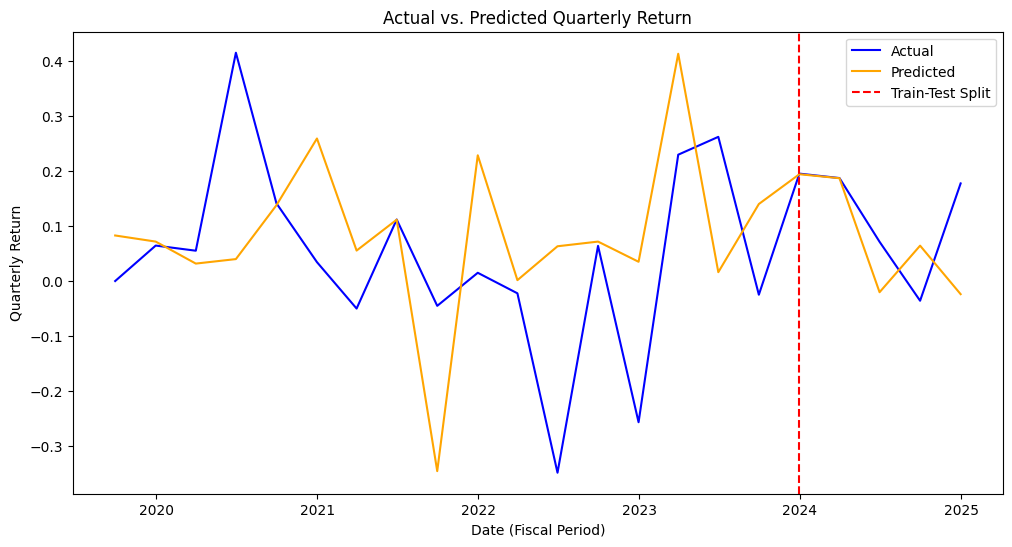

In [ ]:
df = cdnod_df
X = df.drop(columns=["Quarterly_Return", "fiscalDateEnding"])
y = df["Quarterly_Return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_selected = X_train[best['Selected Features']]
X_test_selected = X_test[best['Selected Features']]
train_predictions = best["Best Model"].predict(X_train_selected)
test_predictions = best['Best Model'].predict(X_test_selected)

# Combine actual and predicted values for plotting
df_plot = df.copy()
df_plot["Predicted"] = list(train_predictions) + list(test_predictions)
df_plot["Dataset"] = ["Train"] * len(y_train) + ["Test"] * len(y_test)

# Sort by date for correct visualization
df_plot["fiscalDateEnding"] = pd.to_datetime(df_plot["fiscalDateEnding"])
df_plot = df_plot.sort_values("fiscalDateEnding")

# Plot 
plt.figure(figsize=(12,6))
plt.plot(df_plot["fiscalDateEnding"], df_plot["Quarterly_Return"], label="Actual", color="blue")
plt.plot(df_plot["fiscalDateEnding"], df_plot["Predicted"], label="Predicted", color="orange")

# Mark train-test split
split_index = len(y_train)
plt.axvline(df_plot["fiscalDateEnding"].iloc[split_index], color="red", linestyle="--", label="Train-Test Split")

plt.xlabel("Date (Fiscal Period)")
plt.ylabel("Quarterly Return")
plt.title("Actual vs. Predicted Quarterly Return")
plt.legend()
plt.show()


## ARIMA

ADF Statistic: 0.8273822458331432
P-Value: 0.9920655549595523
Non-stationary

Applied differencing to make data stationary.
ADF Statistic: -2.706780792439294
P-Value: 0.07287222793725855
Non-stationary

ARIMA Model RMSE: 0.2635
ARIMA Model R² Score: -0.0209


/Users/vivianzhao/anaconda3/envs/dsc80/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/Users/vivianzhao/anaconda3/envs/dsc80/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/Users/vivianzhao/anaconda3/envs/dsc80/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/Users/vivianzhao/anaconda3/envs/dsc80/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


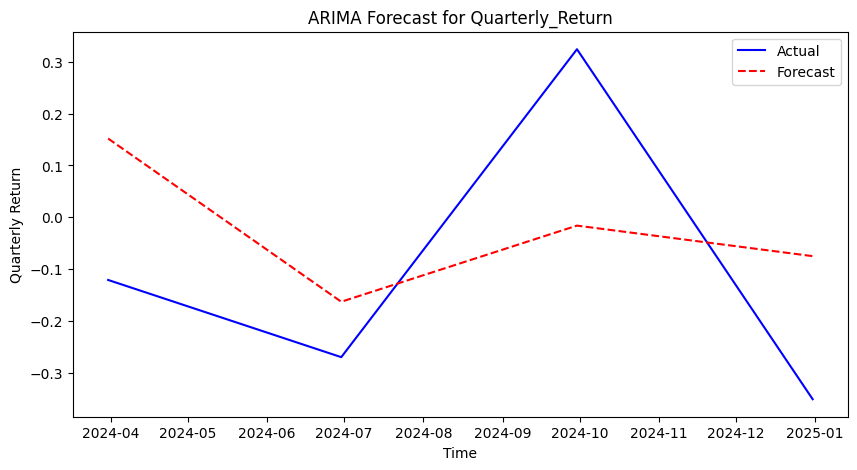

In [ ]:


cdnod_df = cdnod_df.sort_values(by="fiscalDateEnding", ascending=True)
# Ensure the fiscalDateEnding column is datetime format and set as index
cdnod_df["fiscalDateEnding"] = pd.to_datetime(cdnod_df["fiscalDateEnding"])
cdnod_df.set_index("fiscalDateEnding", inplace=True)

# Select target variable (Quarterly_Return)
ts_data = cdnod_df["Quarterly_Return"].dropna()

# 1. Check stationarity with Augmented Dickey-Fuller test
def check_stationarity(data):
    result = adfuller(data)
    print(f"ADF Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-stationary")

check_stationarity(ts_data)

# 2. Differencing if necessary
if adfuller(ts_data)[1] > 0.05:
    ts_data = ts_data.diff().dropna()
    print("\nApplied differencing to make data stationary.")
    check_stationarity(ts_data)

# 3. Define and fit ARIMA model
p, d, q = 2,3,2  # Example values (Can be tuned using AIC/BIC)
model = ARIMA(ts_data, order=(p, d, q))
arima_result = model.fit()

# 4. Forecast future values
forecast_steps = 4  # Change this for longer predictions
forecast = arima_result.forecast(steps=forecast_steps)

# 5. Evaluate model performance
y_test = ts_data[-forecast_steps:]  # Select last 'forecast_steps' as test
y_pred = forecast

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nARIMA Model RMSE: {rmse:.4f}")
print(f"ARIMA Model R² Score: {r2:.4f}")

# 6. Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(ts_data[-forecast_steps:], label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Forecast", linestyle="dashed", color="red")
plt.title("ARIMA Forecast for Quarterly_Return")
plt.xlabel("Time")
plt.ylabel("Quarterly Return")
plt.legend()
plt.show()

## most extreme value

In [ ]:
def get_extreme_by_quarter(stock_data):
    """
    Assigns quarterly labels based on the date, drops NaN rows, 
    and finds the most extreme stock price movement (largest gain or largest drop) within each quarter.
    Keeps only the row with the most extreme value, renames the column to 'Extreme Value',
    and adds a 'Quarter End Date' column with the last date of the respective quarter.

    Parameters:
    - stock_data (pd.DataFrame): DataFrame containing 'Date', 'Close', and 'Daily Return' columns.

    Returns:
    - pd.DataFrame: Filtered stock data containing only the most extreme movement per quarter.
    """
    stock_data["Quarter"] = None 

    # Iterate over each row to assign quarter labels
    for i, row in stock_data.iterrows():
        date = row["Date"]
        year = date.year

        if pd.Timestamp(f"{year}-01-27") <= date <= pd.Timestamp(f"{year}-02-09"):
            stock_data.at[i, "Quarter"] = f"{year-1}-Q4"  # Q4 belongs to the previous year
        elif pd.Timestamp(f"{year}-04-27") <= date <= pd.Timestamp(f"{year}-05-09"):
            stock_data.at[i, "Quarter"] = f"{year}-Q1"
        elif pd.Timestamp(f"{year}-07-27") <= date <= pd.Timestamp(f"{year}-08-09"):
            stock_data.at[i, "Quarter"] = f"{year}-Q2"
        elif pd.Timestamp(f"{year}-10-27") <= date <= pd.Timestamp(f"{year}-11-09"):
            stock_data.at[i, "Quarter"] = f"{year}-Q3"

    # Drop rows where 'Quarter' is NaN
    stock_data = stock_data.dropna(subset=["Quarter"]).copy()

    # Find the most extreme price movement (either largest gain or largest drop) for each quarter
    def find_extreme_row(group):
        max_return_idx = group["Daily Return"].idxmax()  # Index of the max daily return
        min_return_idx = group["Daily Return"].idxmin()  # Index of the min daily return

        max_return = group.loc[max_return_idx, "Daily Return"]
        min_return = group.loc[min_return_idx, "Daily Return"]

        # Determine which is more extreme and keep only that row
        if abs(min_return) > abs(max_return):
            extreme_idx = min_return_idx  # Keep only the row with the most extreme drop
        else:
            extreme_idx = max_return_idx  # Keep only the row with the most extreme gain

        return group.loc[[extreme_idx]]

    # Apply function to each group and reset index
    extreme_stock_data = stock_data.groupby("Quarter", group_keys=False).apply(find_extreme_row).reset_index(drop=True)

    # Rename "Daily Return" to "Extreme Value"
    extreme_stock_data = extreme_stock_data.rename(columns={"Daily Return": "Extreme Value"})

    # Create "Quarter End Date" column based on the quarter label
    def get_quarter_end_date(quarter):
        year, qtr = quarter.split("-")
        quarter_end_dates = {"Q1": "03-31", "Q2": "06-30", "Q3": "09-30", "Q4": "12-31"}
        return f"{year}-{quarter_end_dates[qtr]}"

    extreme_stock_data["Date"] = extreme_stock_data["Quarter"].apply(get_quarter_end_date)

    return extreme_stock_data

In [ ]:
stock = pd.read_csv(os.path.join('/Users/vivianzhao/Desktop/CAPSTONE-stockreturn/data/stock', f"{ticker.lower()}_stock_data.csv"))
stock["Date"] = pd.to_datetime(stock["Date"])
stock.drop(columns = ["Ticker","Industry"], inplace = True)
# get the most extreme value in the quarter
stock_data = get_extreme_by_quarter(stock)
#可以试试看predict quarterly extreme value
predicted = stock_data[["Date","Extreme Value"]]

extreme_df = pd.merge(predicted, cdnod_df, left_on="Date", right_on="fiscalDateEnding", how="inner")



/Users/vivianzhao/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/vivianzhao/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


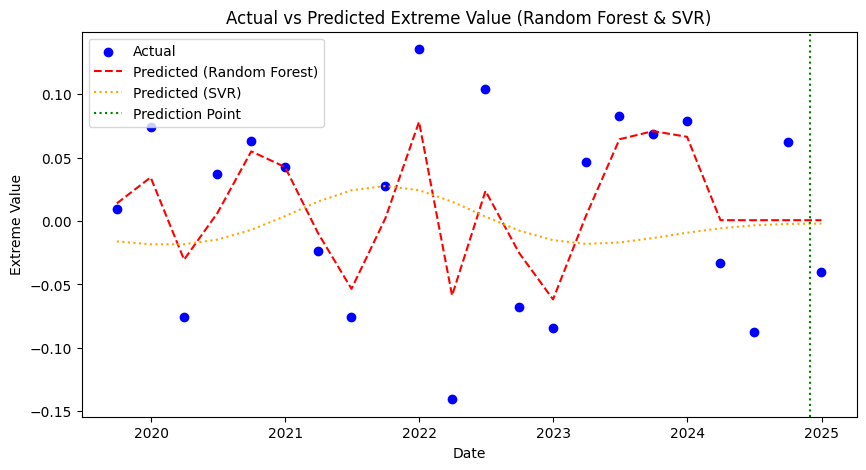

Predicted Extreme Value (Random Forest) for 2024-12-01: 0.0006075666147802891
Predicted Extreme Value (SVR) for 2024-12-01: -0.0022412127872084046


In [ ]:


df = extreme_df
# Convert "fiscalDateEnding" to datetime and sort it
df["fiscalDateEnding"] = pd.to_datetime(df["fiscalDateEnding"])
df = df.sort_values(by="fiscalDateEnding")
df.set_index("fiscalDateEnding", inplace=True)
target_col = "Extreme Value"

# Create a time feature: Numeric representation of time for regression
df["time"] = np.arange(len(df))

# Train-test split 
X = df[["time"]]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train an SVR model
svr_model = SVR(kernel="rbf", C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict
future_time = np.array([[len(df)]])  # Next time step
future_prediction_rf = rf_model.predict(future_time)[0]
future_prediction_svr = svr_model.predict(future_time)[0]

# Plot 
plt.figure(figsize=(10, 5))
plt.scatter(df.index, df[target_col], label="Actual", color="blue")
plt.plot(df.index, rf_model.predict(X), label="Predicted (Random Forest)", color="red", linestyle="dashed")
plt.plot(df.index, svr_model.predict(X), label="Predicted (SVR)", color="orange", linestyle="dotted")
plt.axvline(pd.Timestamp("2024-12-01"), color="green", linestyle="dotted", label="Prediction Point")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Extreme Value")
plt.title("Actual vs Predicted Extreme Value (Random Forest & SVR)")
plt.show()

print(f"Predicted Extreme Value (Random Forest) for 2024-12-01: {future_prediction_rf}")
print(f"Predicted Extreme Value (SVR) for 2024-12-01: {future_prediction_svr}")
